<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Processing-data" data-toc-modified-id="Processing-data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Processing data</a></span></li></ul></div>

In [1]:
import cv2
from datetime import timedelta
import matplotlib.pyplot as plt
import numpy as np
import odc.stac
import pandas as pd
from pathlib import Path
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

%matplotlib inline

In [2]:
metadata = pd.read_csv("Data/metadata.csv")
metadata.head()

,uid,latitude,longitude,date,split
0,aabm,39.080319,-86.430867,2018-05-14,train
1,aabn,36.559700,-121.510000,2016-08-31,test
2,aacd,35.875083,-78.878434,2020-11-19,train
3,aaee,35.487000,-79.062133,2016-08-24,train
4,aaff,38.049471,-99.827001,2019-07-23,train


In [3]:
metadata.split.value_counts(dropna=False)

train    17060
test      6510
Name: split, dtype: int64

In [4]:
import geopandas as gpd
from shapely.geometry import Point

# load the default geopandas base map file to plot points on
world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

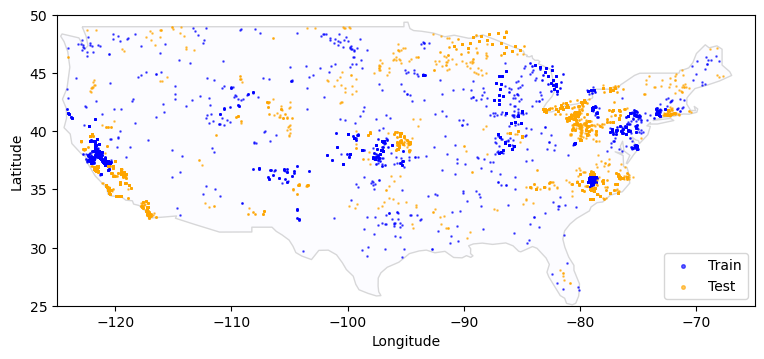

In [5]:
fig, ax = plt.subplots(figsize=(9, 4))

# map the training data
base = world[world.name == "United States of America"].plot(
    edgecolor="gray", color="ghostwhite", figsize=(9, 4), alpha=0.3, ax=ax
)
train_meta = metadata[metadata["split"] == "train"]
geometry = [Point(xy) for xy in zip(train_meta["longitude"], train_meta["latitude"])]
gdf = gpd.GeoDataFrame(train_meta, geometry=geometry)
gdf.plot(ax=base, marker=".", markersize=3, color="blue", label="Train", alpha=0.6)

# map the test data
test_meta = metadata[metadata["split"] == "test"]
geometry = [Point(xy) for xy in zip(test_meta["longitude"], test_meta["latitude"])]
gdf = gpd.GeoDataFrame(test_meta, geometry=geometry)
gdf.plot(ax=base, marker=".", markersize=3, color="orange", label="Test", alpha=0.6)

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.xlim([-125, -65])
plt.ylim([25, 50])
plt.legend(loc=4, markerscale=3)

In [6]:
# convert date to pd.datetime
metadata.date = pd.to_datetime(metadata.date)

# what is the date range?
metadata.groupby("split").agg(min_date=("date", min), max_date=("date", max))

,min_date,max_date
split,,
test,2013-01-08,2021-12-29
train,2013-01-04,2021-12-14


Text(0.5, 1.0, 'Distribution of years in the data')

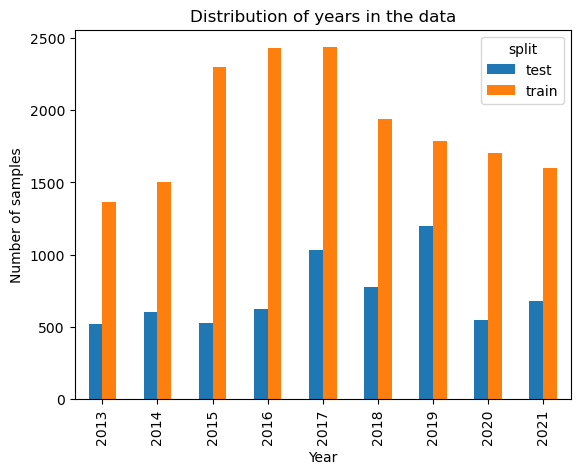

In [7]:
# what years are in the data?
pd.crosstab(metadata.date.dt.year, metadata.split).plot(kind="bar")
plt.ylabel("Number of samples")
plt.xlabel("Year")
plt.title("Distribution of years in the data")

In [8]:
# what seasons are the data points from?
metadata["season"] = (
    metadata.date.dt.month.replace([12, 1, 2], "winter")
    .replace([3, 4, 5], "spring")
    .replace([6, 7, 8], "summer")
    .replace([9, 10, 11], "fall")
)
metadata.season.value_counts()

summer    10813
spring     5045
fall       4758
winter     2954
Name: season, dtype: int64

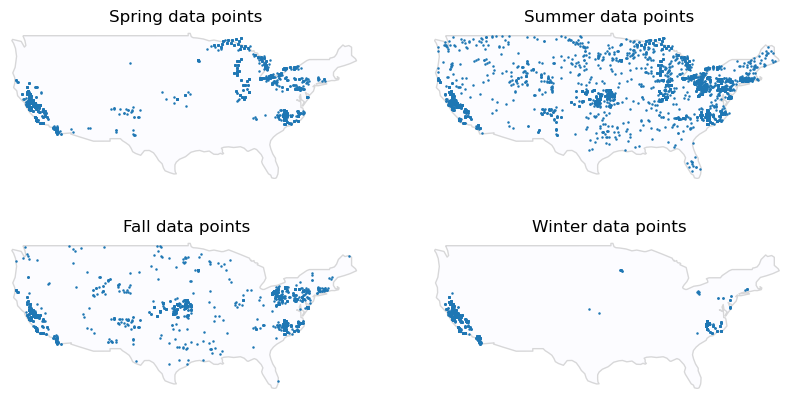

In [9]:
# where is data from for each season?
fig, axes = plt.subplots(2, 2, figsize=(10, 5))

for season, ax in zip(metadata.season.unique(), axes.flatten()):
    base = world[world.name == "United States of America"].plot(
        edgecolor="gray", color="ghostwhite", alpha=0.3, ax=ax
    )

    sub = metadata[metadata.season == season]
    geometry = [Point(xy) for xy in zip(sub["longitude"], sub["latitude"])]
    gdf = gpd.GeoDataFrame(sub, geometry=geometry)
    gdf.plot(ax=base, marker=".", markersize=2.5)
    ax.set_xlim([-125, -66])
    ax.set_ylim([25, 50])
    ax.set_title(f"{season.capitalize()} data points")
    ax.axis("off")

In [10]:
train_labels = pd.read_csv("Data/train_labels.csv")
train_labels.head()

,uid,region,severity,density
0,aabm,midwest,1,585.0
1,aacd,south,1,290.0
2,aaee,south,1,1614.0
3,aaff,midwest,3,111825.0
4,aafl,midwest,4,2017313.0


In [11]:
train_labels.shape

(17060, 4)

In [12]:
train_labels_and_metadata = train_labels.merge(
    metadata, how="left", left_on="uid", right_on="uid", validate="1:1"
)

Text(0.5, 1.0, 'Train labels severity level counts')

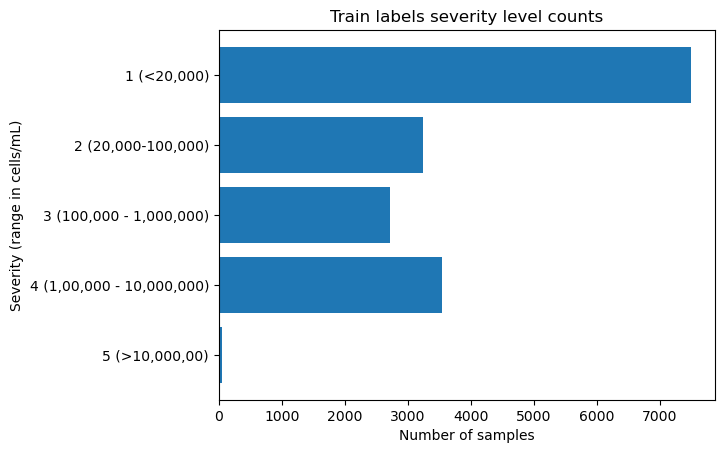

In [13]:
severity_counts = (
    train_labels.replace(
        {
            "severity": {
                1: "1 (<20,000)",
                2: "2 (20,000-100,000)",
                3: "3 (100,000 - 1,000,000)",
                4: "4 (1,00,000 - 10,000,000)",
                5: "5 (>10,000,00)",
            }
        }
    )
    .severity.value_counts()
    .sort_index(ascending=False)
)
plt.barh(severity_counts.index, severity_counts.values)
plt.xlabel("Number of samples")
plt.ylabel("Severity (range in cells/mL)")
plt.title("Train labels severity level counts")

In [14]:
train_labels.density.describe()

count    1.706000e+04
mean     1.074537e+06
std      6.836693e+06
min      0.000000e+00
25%      4.066000e+03
50%      3.270975e+04
75%      4.849192e+05
max      8.046675e+08
Name: density, dtype: float64

In [15]:
(train_labels.density == 0).sum()

91

# Processing data

In [16]:
# Establish a connection to the STAC API
import planetary_computer as pc
from pystac_client import Client

catalog = Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1", modifier=pc.sign_inplace
)

In [17]:
example_row = metadata[metadata.uid == "garm"].iloc[0]
example_row

uid                         garm
latitude                41.98006
longitude             -110.65734
date         2021-09-27 00:00:00
split                      train
season                      fall
Name: 5461, dtype: object

In [18]:
import geopy.distance as distance

In [19]:
# get our bounding box to search latitude and longitude coordinates
def get_bounding_box(latitude, longitude, meter_buffer=50000):
    """
    Given a latitude, longitude, and buffer in meters, returns a bounding
    box around the point with the buffer on the left, right, top, and bottom.

    Returns a list of [minx, miny, maxx, maxy]
    """
    distance_search = distance.distance(meters=meter_buffer)

    # calculate the lat/long bounds based on ground distance
    # bearings are cardinal directions to move (south, west, north, and east)
    min_lat = distance_search.destination((latitude, longitude), bearing=180)[0]
    min_long = distance_search.destination((latitude, longitude), bearing=270)[1]
    max_lat = distance_search.destination((latitude, longitude), bearing=0)[0]
    max_long = distance_search.destination((latitude, longitude), bearing=90)[1]

    return [min_long, min_lat, max_long, max_lat]


bbox = get_bounding_box(example_row.latitude, example_row.longitude, meter_buffer=50000)
bbox

[-111.26063646639783,
 41.52988747516146,
 -110.05404353360218,
 42.43019710235757]

In [22]:
# get our date range to search, and format correctly for query
def get_date_range(date, time_buffer_days=15):
    """Get a date range to search for in the planetary computer based
    on a sample's date. The time range will include the sample date
    and time_buffer_days days prior

    Returns a string"""
    datetime_format = "%Y-%m-%d"
    range_start = pd.to_datetime(date) - timedelta(days=time_buffer_days)
    date_range = f"{range_start.strftime(datetime_format)}/{pd.to_datetime(date).strftime(datetime_format)}"

    return date_range


date_range = get_date_range(example_row.date)
date_range

'2021-09-12/2021-09-27'

In [23]:
# search the planetary computer sentinel-l2a and landsat level-2 collections
search = catalog.search(
    collections=["sentinel-2-l2a", "landsat-c2-l2"], bbox=bbox, datetime=date_range
)

# see how many items were returned
items = [item for item in search.get_all_items()]
len(items)

46

In [24]:
# get details of all of the items returned
item_details = pd.DataFrame(
    [
        {
            "datetime": item.datetime.strftime("%Y-%m-%d"),
            "platform": item.properties["platform"],
            "min_long": item.bbox[0],
            "max_long": item.bbox[2],
            "min_lat": item.bbox[1],
            "max_lat": item.bbox[3],
            "bbox": item.bbox,
            "item_obj": item,
        }
        for item in items
    ]
)

# check which rows actually contain the sample location
item_details["contains_sample_point"] = (
    (item_details.min_lat < example_row.latitude)
    & (item_details.max_lat > example_row.latitude)
    & (item_details.min_long < example_row.longitude)
    & (item_details.max_long > example_row.longitude)
)

print(
    f"Filtering from {len(item_details)} returned to {item_details.contains_sample_point.sum()} items that contain the sample location"
)

item_details = item_details[item_details["contains_sample_point"]]
item_details[["datetime", "platform", "contains_sample_point", "bbox"]].sort_values(
    by="datetime"
)

Filtering from 46 returned to 7 items that contain the sample location


,datetime,platform,contains_sample_point,bbox
44,2021-09-12,landsat-8,True,"[-111.34023745, 40.67702495, -108.51528663, 42..."
34,2021-09-14,Sentinel-2A,True,"[-111.000244, 41.45624189757688, -109.665115, ..."
21,2021-09-19,Sentinel-2B,True,"[-111.000244, 41.45624189757688, -109.665115, ..."
26,2021-09-19,landsat-8,True,"[-112.92522743, 40.67353498, -110.06644659, 42..."
18,2021-09-20,landsat-7,True,"[-111.60018779, 40.80284495, -108.59831681, 42..."
8,2021-09-24,Sentinel-2A,True,"[-111.000244, 41.4562419, -109.665115, 42.4526..."
5,2021-09-27,landsat-7,True,"[-113.18385774, 40.78803499, -110.15150674, 42..."


In [25]:
# 1 - filter to sentinel
item_details[item_details.platform.str.contains("Sentinel")]

,datetime,platform,min_long,max_long,min_lat,max_lat,bbox,item_obj,contains_sample_point
8,2021-09-24,Sentinel-2A,-111.000244,-109.665115,41.456242,42.452691,"[-111.000244, 41.4562419, -109.665115, 42.4526...",<Item id=S2A_MSIL2A_20210924T181101_R084_T12TW...,True
21,2021-09-19,Sentinel-2B,-111.000244,-109.665115,41.456242,42.452691,"[-111.000244, 41.45624189757688, -109.665115, ...",<Item id=S2B_MSIL2A_20210919T180919_R084_T12TW...,True
34,2021-09-14,Sentinel-2A,-111.000244,-109.665115,41.456242,42.452691,"[-111.000244, 41.45624189757688, -109.665115, ...",<Item id=S2A_MSIL2A_20210914T180951_R084_T12TW...,True


In [26]:
# 2 - take closest by date
best_item = (
    item_details[item_details.platform.str.contains("Sentinel")]
    .sort_values(by="datetime", ascending=False)
    .iloc[0]
)
best_item

datetime                                                        2021-09-24
platform                                                       Sentinel-2A
min_long                                                       -111.000244
max_long                                                       -109.665115
min_lat                                                          41.456242
max_lat                                                          42.452691
bbox                     [-111.000244, 41.4562419, -109.665115, 42.4526...
item_obj                 <Item id=S2A_MSIL2A_20210924T181101_R084_T12TW...
contains_sample_point                                                 True
Name: 8, dtype: object

In [27]:
item = best_item.item_obj

In [28]:
# What assets are available?
for asset_key, asset in item.assets.items():
    print(f"{asset_key:<25} - {asset.title}")

AOT                       - Aerosol optical thickness (AOT)
B01                       - Band 1 - Coastal aerosol - 60m
B02                       - Band 2 - Blue - 10m
B03                       - Band 3 - Green - 10m
B04                       - Band 4 - Red - 10m
B05                       - Band 5 - Vegetation red edge 1 - 20m
B06                       - Band 6 - Vegetation red edge 2 - 20m
B07                       - Band 7 - Vegetation red edge 3 - 20m
B08                       - Band 8 - NIR - 10m
B09                       - Band 9 - Water vapor - 60m
B11                       - Band 11 - SWIR (1.6) - 20m
B12                       - Band 12 - SWIR (2.2) - 20m
B8A                       - Band 8A - Vegetation red edge 4 - 20m
SCL                       - Scene classfication map (SCL)
WVP                       - Water vapour (WVP)
visual                    - True color image
preview                   - Thumbnail
safe-manifest             - SAFE manifest
granule-metadata          - Granul

In [29]:
import rioxarray
from IPython.display import Image
from PIL import Image as PILImage

In [30]:
# see the whole image
img = Image(url=item.assets["rendered_preview"].href, width=500)

Image(url=item.assets["rendered_preview"].href, width=500)

In [31]:
def crop_sentinel_image(item, bounding_box):
    """
    Given a STAC item from Sentinel-2 and a bounding box tuple in the format
    (minx, miny, maxx, maxy), return a cropped portion of the item's visual
    imagery in the bounding box.

    Returns the image as a numpy array with dimensions (color band, height, width)
    """
    (minx, miny, maxx, maxy) = bounding_box

    image = rioxarray.open_rasterio(pc.sign(item.assets["visual"].href)).rio.clip_box(
        minx=minx,
        miny=miny,
        maxx=maxx,
        maxy=maxy,
        crs="EPSG:4326",
    )

    return image.to_numpy()

In [32]:
# get a smaller geographic bounding box
minx, miny, maxx, maxy = get_bounding_box(
    example_row.latitude, example_row.longitude, meter_buffer=3000
)

# get the zoomed in image array
bbox = (minx, miny, maxx, maxy)
zoomed_img_array = crop_sentinel_image(item, bbox)

zoomed_img_array[0]

array([[214, 224, 213, ..., 124, 109, 103],
       [215, 220, 201, ..., 114,  95,  94],
       [217, 222, 187, ..., 106,  95,  94],
       ...,
       [223, 185, 193, ..., 112, 118, 120],
       [181, 140, 190, ..., 110, 111, 117],
       [134, 125, 185, ..., 107, 107, 111]], dtype=uint8)

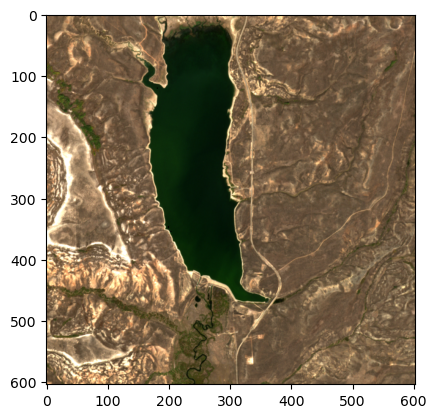

In [33]:
# we have to transpose some of the dimensions to plot
# matplotlib expects channels in a certain order
plt.imshow(np.transpose(zoomed_img_array, axes=[1, 2, 0]))

In [34]:
landsat_item = (
    item_details[item_details.platform.str.contains("landsat")]
    .sample(n=1, random_state=3)
    .iloc[0]
)
landsat_item

datetime                                                        2021-09-12
platform                                                         landsat-8
min_long                                                       -111.340237
max_long                                                       -108.515287
min_lat                                                          40.677025
max_lat                                                          42.817595
bbox                     [-111.34023745, 40.67702495, -108.51528663, 42...
item_obj                         <Item id=LC08_L2SP_037031_20210912_02_T1>
contains_sample_point                                                 True
Name: 44, dtype: object

In [35]:
def crop_landsat_image(item, bounding_box):
    """
    Given a STAC item from Landsat and a bounding box tuple in the format
    (minx, miny, maxx, maxy), return a cropped portion of the item's visual
    imagery in the bounding box.

    Returns the image as a numpy array with dimensions (color band, height, width)
    """
    (minx, miny, maxx, maxy) = bounding_box

    image = odc.stac.stac_load(
        [pc.sign(item)], bands=["red", "green", "blue"], bbox=[minx, miny, maxx, maxy]
    ).isel(time=0)
    image_array = image[["red", "green", "blue"]].to_array().to_numpy()

    # normalize to 0 - 255 values
    image_array = cv2.normalize(image_array, None, 0, 255, cv2.NORM_MINMAX)

    return image_array

In [36]:
item = landsat_item.item_obj

# we'll use the same cropped area as above
landsat_image_array = crop_landsat_image(item, bbox)
landsat_image_array[0]

array([[104, 108,  94, ...,  85,  86,  88],
       [106, 110,  95, ...,  86,  89,  87],
       [106, 105,  94, ...,  89,  89,  85],
       ...,
       [106, 100,  96, ...,  90,  89,  90],
       [ 95,  93,  92, ...,  89,  88,  88],
       [113, 105, 103, ...,  88,  87,  89]], dtype=uint16)

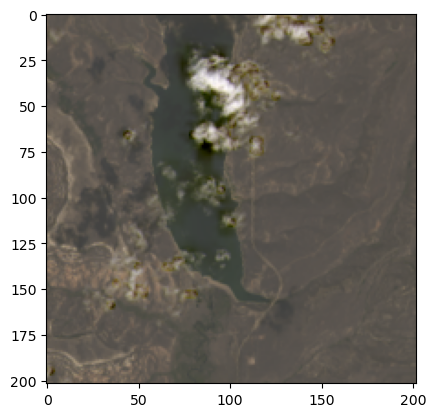

In [37]:
plt.imshow(np.transpose(landsat_image_array, axes=[1, 2, 0]))

In [38]:
# load image but don't convert to numpy or rescale
image = odc.stac.stac_load(
    [pc.sign(item)], bands=["red", "green", "blue"], bbox=bbox
).isel(time=0)
image_array = image[["red", "green", "blue"]].to_array()

# values are not scaled 0 - 255 when first returned
image_array[0]

<xarray.DataArray (y: 202, x: 202)>
array([[12933, 13488, 11722, ..., 10544, 10770, 10988],
       [13164, 13673, 11810, ..., 10660, 11079, 10844],
       [13250, 13085, 11760, ..., 11094, 11137, 10551],
       ...,
       [13158, 12414, 11900, ..., 11263, 11087, 11157],
       [11882, 11630, 11493, ..., 11082, 10912, 10931],
       [14101, 13137, 12880, ..., 10945, 10871, 11113]], dtype=uint16)
Coordinates:
  * y            (y) float64 4.651e+06 4.651e+06 ... 4.645e+06 4.645e+06
  * x            (x) float64 5.254e+05 5.254e+05 ... 5.314e+05 5.314e+05
    spatial_ref  int32 32612
    time         datetime64[ns] 2021-09-12T18:01:53.979983
    variable     <U3 'red'

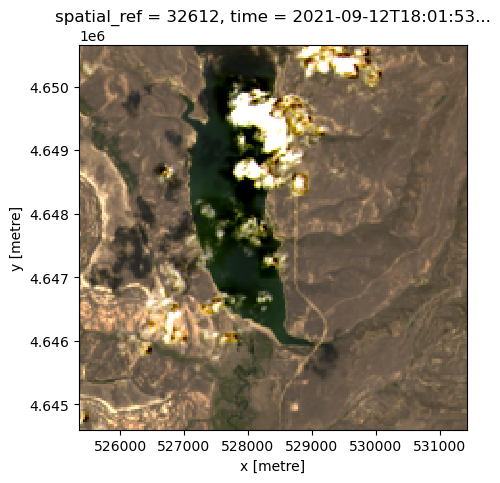

In [39]:
# image appears differently without rescaling
fig, ax = plt.subplots(figsize=(5, 5))
image_array.plot.imshow(robust=True, ax=ax)

In [40]:
# define a small area to crop around
# crop to 400 meters squared around the sampling point
minx, miny, maxx, maxy = get_bounding_box(
    example_row.latitude, example_row.longitude, meter_buffer=100
)
minx, miny, maxx, maxy

(-110.65854661288282,
 41.97915969028358,
 -110.6561333871172,
 41.980960309574755)

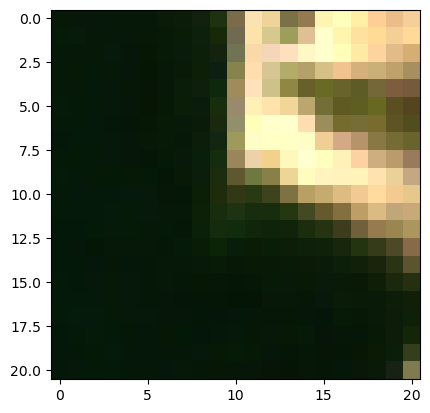

In [41]:
bbox = (minx, miny, maxx, maxy)
feature_image_array = crop_sentinel_image(best_item.item_obj, bounding_box=bbox)

plt.imshow(np.transpose(feature_image_array, axes=[1, 2, 0]))

In [42]:
type(feature_image_array), feature_image_array.shape

(numpy.ndarray, (3, 21, 21))

In [43]:
# take the average over the second and third dimensions
image_color_averages = feature_image_array.mean(axis=(1, 2)).tolist()

# also take the median
image_color_medians = np.median(feature_image_array, axis=(1, 2)).tolist()

# concatenate the two lists
image_features = image_color_averages + image_color_medians
image_features

[64.1156462585034, 71.21541950113378, 42.44897959183673, 8.0, 26.0, 9.0]

In [44]:
# Refactor our process from above into functions
def select_best_item(items, date, latitude, longitude):
    """
    Select the best satellite item given a sample's date, latitude, and longitude.
    If any Sentinel-2 imagery is available, returns the closest sentinel-2 image by
    time. Otherwise, returns the closest Landsat imagery.

    Returns a tuple of (STAC item, item platform name, item date)
    """
    # get item details
    item_details = pd.DataFrame(
        [
            {
                "datetime": item.datetime.strftime("%Y-%m-%d"),
                "platform": item.properties["platform"],
                "min_long": item.bbox[0],
                "max_long": item.bbox[2],
                "min_lat": item.bbox[1],
                "max_lat": item.bbox[3],
                "item_obj": item,
            }
            for item in items
        ]
    )

    # filter to items that contain the point location, or return None if none contain the point
    item_details["contains_sample_point"] = (
        (item_details.min_lat < latitude)
        & (item_details.max_lat > latitude)
        & (item_details.min_long < longitude)
        & (item_details.max_long > longitude)
    )
    item_details = item_details[item_details["contains_sample_point"] == True]
    if len(item_details) == 0:
        return (np.nan, np.nan, np.nan)

    # add time difference between each item and the sample
    item_details["time_diff"] = pd.to_datetime(date) - pd.to_datetime(
        item_details["datetime"]
    )

    # if we have sentinel-2, filter to sentinel-2 images only
    item_details["sentinel"] = item_details.platform.str.lower().str.contains(
        "sentinel"
    )
    if item_details["sentinel"].any():
        item_details = item_details[item_details["sentinel"] == True]

    # return the closest imagery by time
    best_item = item_details.sort_values(by="time_diff", ascending=True).iloc[0]

    return (best_item["item_obj"], best_item["platform"], best_item["datetime"])


def image_to_features(image_array):
    """
    Convert an image array of the form (color band, height, width) to a
    1-dimensional list of features. Returns a list where the first three
    values are the averages of each color band, and the second three
    values are the medians of each color band.
    """
    averages = image_array.mean(axis=(1, 2)).tolist()
    medians = np.median(image_array, axis=(1, 2)).tolist()

    return averages + medians

In [45]:
# take a random subset of the training data for the benchmark
train_subset = metadata[metadata["split"] == "train"].sample(n=2500, random_state=2)

# combine train subset with all test data
metadata_subset = pd.concat([train_subset, metadata[metadata["split"] == "test"]])
metadata_subset.split.value_counts(dropna=False)

test     6510
train    2500
Name: split, dtype: int64

In [47]:
test = metadata_subset[:100]

In [51]:
test

,uid,latitude,longitude,date,split,season
18584,umac,40.090275,-76.873132,2018-05-21,train,spring
3880,egox,35.720081,-79.137421,2013-05-22,train,spring
6366,havx,35.694025,-79.185817,2016-10-18,train,fall
10054,laoq,35.682250,-79.078020,2015-03-24,train,spring
17961,ttsk,35.790000,-79.026491,2018-07-11,train,summer
...,...,...,...,...,...,...
5614,gfee,41.319500,-75.045640,2020-08-26,train,summer
11988,nelu,35.790000,-79.023871,2017-09-20,train,fall
9118,kbkc,38.210400,-121.262000,2017-01-05,train,winter
9267,kfim,35.740000,-79.020000,2017-07-20,train,summer


In [50]:
# this cell takes a LONG time because it iterates over all data!

# save outputs in dictionaries
selected_items = {}
features_dict = {}
errored_ids = []


for row in tqdm(test.itertuples(), total=len(test)):
    pass
    # check if we've already saved the selected image array
#     image_array_pth = IMAGE_ARRAY_DIR / f"{row.uid}.npy"

#     if image_array_pth.exists():
#         with open(image_array_pth, "rb") as f:
#             image_array = np.load(f)

#         # convert image to 1-dimensional features
#         image_features = image_to_features(image_array)
#         features_dict[row.uid] = image_features

    # search and load the image array if not
#     else:
    try:
        ## QUERY STAC API
        # get query ranges for location and date
        search_bbox = get_bounding_box(
            row.latitude, row.longitude, meter_buffer=50000
        )
        date_range = get_date_range(row.date, time_buffer_days=15)

        # search the planetary computer
        search = catalog.search(
            collections=["sentinel-2-l2a", "landsat-c2-l2"],
            bbox=search_bbox,
            datetime=date_range,
        )
        items = [item for item in search.get_all_items()]

        ## GET BEST IMAGE
        if len(items) == 0:
            pass
        else:
            best_item, item_platform, item_date = select_best_item(
                items, row.date, row.latitude, row.longitude
            )
            # add to dictionary tracking best items
            selected_items[row.uid] = {
                "item_object": best_item,
                "item_platform": item_platform,
                "item_date": item_date,
            }

        ## CONVERT TO FEATURES
        # get small bbox just for features
        feature_bbox = get_bounding_box(
            row.latitude, row.longitude, meter_buffer=100
        )

        # crop the image
        if "sentinel" in item_platform.lower():
            image_array = crop_sentinel_image(best_item, feature_bbox)
        else:
            image_array = crop_landsat_image(best_item, feature_bbox)

        # save image array so we don't have to rerun
        with open(image_array_pth, "wb") as f:
            np.save(f, image_array)

        # convert image to 1-dimensional features
        image_features = image_to_features(image_array)
        features_dict[row.uid] = image_features

    # keep track of any that ran into errors without interrupting the process
    except:
        errored_ids.append(row.uid)

100%|██████████| 100/100 [01:54<00:00,  1.14s/it]
